In [1]:
!pip3 install torch torchvision

  Using cached https://files.pythonhosted.org/packages/e0/50/8e78e6f62ffa50d6ca95c281d5a2819bef66d023ac1b723e253de5bda9c5/Pillow-7.1.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [5]:
!ls

ants_and_bees  sample_data


In [6]:
!ls ants_and_bees

train  val


In [7]:
!ls ants_and_bees/train 

ants  bees


In [8]:
!ls ants_and_bees/train/ants 

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

In [9]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
                                      transforms.ColorJitter(brightness = 1, contrast = 1, saturation = 1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.ImageFolder(root='/content/ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder(root='/content/ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [10]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [11]:
def im_convert(tensor):  #.cpu() is because CUDA can not convert to numpy arrays
  image = tensor.cpu().clone().detach().numpy()  #creating a copy, detach any existing graphs etc, and convert to numpy
  image = image.transpose(1, 2, 0)  #(1, 28, 28) to (28, 28, 1)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [12]:
classes = ('ant', 'bee')

In [13]:
!pip install Pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.6.0+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


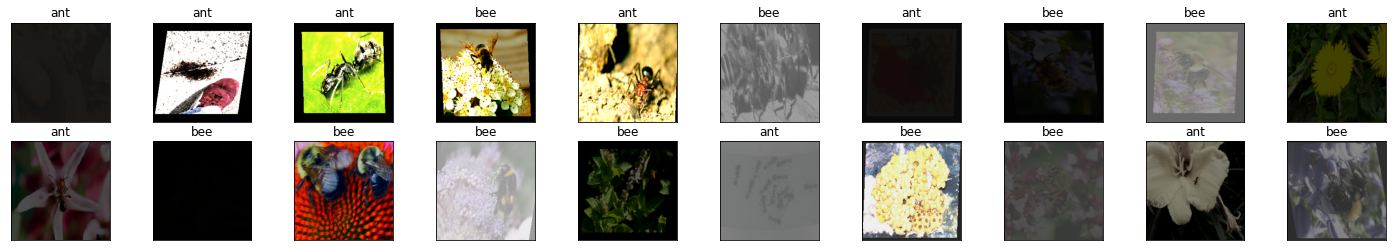

In [14]:
dataiter = iter(training_loader)  #iteration through a batch of images
images, labels = dataiter.next()  #next batch
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))  #need to convert to np array to display
  ax.set_title(classes[labels[idx].item()])

In [15]:
model = models.vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [16]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
for param in model.features.parameters():
  param.requires_grad = False

In [18]:
import torch.nn as nn

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)

print(model.classifier[6].out_features)

2


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)  #adaptive descent for each param

In [ ]:
# epochs = 15
# running_loss_history = []
# running_corrects_history = []
# val_running_loss_history = []
# val_running_corrects_history = []

# for e in range(epochs):
  
#   running_loss = 0.0
#   running_corrects = 0.0
#   val_running_loss = 0.0
#   val_running_corrects = 0.0
  
#   for inputs, labels in training_loader:
#     inputs = inputs.view(inputs.shape[0], -1)
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     _, preds = torch.max(outputs, 1)
#     running_loss += loss.item()
#     running_corrects += torch.sum(preds == labels.data)

#   else:
#     with torch.no_grad():
#       for val_inputs, val_labels in validation_loader:
#         val_inputs = val_inputs.view(val_inputs.shape[0], -1)
#         val_outputs = model(val_inputs)
#         val_loss = criterion(val_outputs, val_labels)
        
#         _, val_preds = torch.max(val_outputs, 1)
#         val_running_loss += val_loss.item()
#         val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#     epoch_loss = running_loss/len(training_loader)
#     epoch_acc = running_corrects.float()/ len(training_loader)
#     running_loss_history.append(epoch_loss)
#     running_corrects_history.append(epoch_acc)
    
#     val_epoch_loss = val_running_loss/len(validation_loader)
#     val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
#     val_running_loss_history.append(val_epoch_loss)
#     val_running_corrects_history.append(val_epoch_acc)
#     print('epoch :', (e+1))
#     print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
#     print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

In [20]:
epochs = 5
running_loss_history = []
running_corrects_history = []
running_val_loss_history = []
running_val_corrects_history = []

for e in range(epochs):

  running_loss = 0.
  running_corrects = 0. 
  running_val_loss = 0.
  running_val_corrects = 0.

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)  #1st return value is the winning class score and preds is the winning class, stores in tensors for the data in current batch
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)   #the == returns in form [0, 1, 0, ...] where 1 is if the correct class is predicted, sum of all correct classes

  else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)

          _, val_preds = torch.max(val_outputs, 1)
          running_val_loss += val_loss.item()
          running_val_corrects += torch.sum(val_preds == val_labels.data)

      val_epoch_loss = running_val_loss / len(validation_loader.dataset)
      val_epoch_acc = running_val_corrects.float() / len(validation_loader.dataset)
      running_val_loss_history.append(val_epoch_loss)
      running_val_corrects_history.append(val_epoch_acc)    

      epoch_loss = running_loss / len(training_loader.dataset)    #here also we can divide by len(training_loader.dataset)
      epoch_acc = running_corrects.float() / len(training_loader.dataset)   #Here we have taken the batch size as 100 so we get auto percentages, instead we can change the batch size and divide by len(training_dataset) as it will give us a probability of correctly classified images
      running_loss_history.append(epoch_loss)                          #Same applies to validation set
      running_corrects_history.append(epoch_acc)

      print("Epoch: {}".format(e))
      print("Training Loss : {:.4}, Acc : {:.4}".format(epoch_loss, epoch_acc.item()))
      print("Validation Loss : {:.4}, Acc : {:.4}".format(val_epoch_loss, val_epoch_acc.item()))

Epoch: 0
Training Loss : 0.03009, Acc : 0.6516
Validation Loss : 0.01394, Acc : 0.9085
Epoch: 1
Training Loss : 0.01812, Acc : 0.8443
Validation Loss : 0.01255, Acc : 0.9346
Epoch: 2
Training Loss : 0.01338, Acc : 0.8975
Validation Loss : 0.01826, Acc : 0.915
Epoch: 3
Training Loss : 0.01649, Acc : 0.8566
Validation Loss : 0.01736, Acc : 0.915
Epoch: 4
Training Loss : 0.01127, Acc : 0.9098
Validation Loss : 0.01954, Acc : 0.915


In [21]:
print(len(training_loader.dataset))

244


In [ ]:
# epochs = 12
# running_loss_history = []
# running_corrects_history = []

# for e in range(epochs):

#   running_loss = 0.
#   running_corrects = 0. 

#   for inputs, labels in training_loader:
#     inputs = inputs.view(inputs.shape[0], -1)
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     _, preds = torch.max(outputs, 1)  #1st return value is the winning class score and preds is the winning class, stores in tensors for the data in current batch
#     running_loss += loss.item()
#     running_corrects += torch.sum(preds == labels.data)   #the == returns in form [0, 1, 0, ...] where 1 is if the correct class is predicted, sum of all correct classes

#   else:
#       epoch_loss = running_loss / len(training_loader)
#       epoch_acc = running_corrects.float() / len(training_loader)
#       running_loss_history.append(epoch_loss)
#       running_corrects_history.append(epoch_acc)
#       print("Training Loss : {:.4}, Acc : {:.4}".format(epoch_loss, epoch_acc.item()))

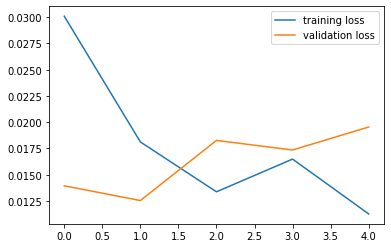

In [22]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(running_val_loss_history, label = 'validation loss')
plt.legend()

#Dropout helps to reduce the generalization error and hence reduces overfitting

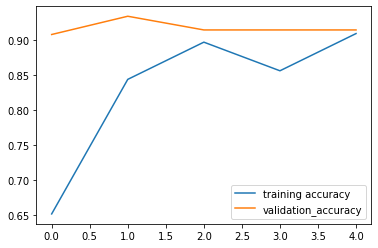

In [23]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(running_val_corrects_history, label = 'validation_accuracy')
plt.legend()

In [24]:
import PIL.ImageOps

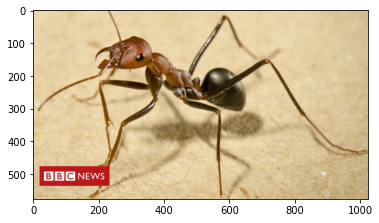

In [25]:
import requests
from PIL import Image

url = 'https://ichef.bbci.co.uk/news/1024/branded_news/16DF4/production/_93648639_ant.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

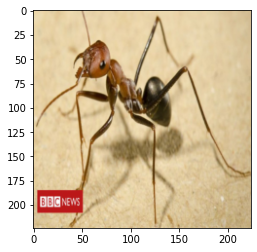

In [26]:
img = transform(img)  #resizing etc
plt.imshow(im_convert(img))

In [27]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


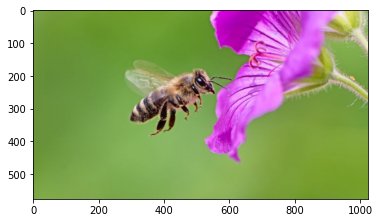

In [29]:
url = 'https://ichef.bbci.co.uk/news/1024/cpsprodpb/F26F/production/_105636026_gettyimages-1005384726.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

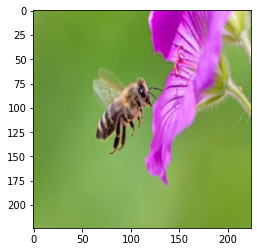

In [30]:
img = transform(img)  #resizing etc
plt.imshow(im_convert(img))

In [31]:

image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])


bee


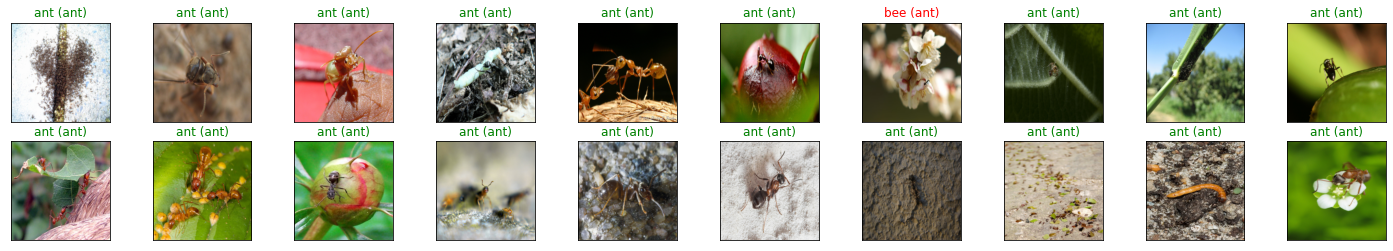

In [32]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.to(device)  #no need to unsqueeze as we are passing in batches that will take care of extra dims
labels = labels.to(device)
outputs = model(images_)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx] == labels[idx] else "red"))
